# Intra class Clustering for athletics class

## Data gathering and preprocessing

Importing/installing necessary modules

In [1]:
#OS module in Python provides functions for interacting with the operating system.
import os
import os.path
# Pandas is used for data manipulation and analysis
import pandas as pd
# NumPy is a general-purpose array-processing package
import numpy as np
# CSV (Comma Separated Values) format is the most common import and export format for spreadsheets and databases
import csv
# glob module is used to retrieve files/pathnames matching a specified pattern
import glob
# RegEx in Python supports various things like Modifiers, Identifiers, and White space characters. Identifiers
import re

Reading and transpose of files in the specified path using csv, pandas and glob

In [2]:
def read_file(main_df, category):
    for filename in glob.glob('/Users/srirambharadwaj/Downloads/bbcsport/athletics' + '/*'):
        df = pd.read_csv(filename, sep = "\n", header = None, quoting=csv.QUOTE_NONE)
        df = df.transpose()
        df['text']= df.apply(lambda x: '\n'.join(x.dropna().astype(str)),axis=1)
        df = df.drop(df.columns[:-1], axis=1)
        df['label'] = category
        main_df = pd.concat([main_df,df],ignore_index=True)
    return main_df

Making use of Data frame to store the data and lablelling/ Data exploration

In [3]:
df_news= pd.DataFrame(columns=['text','label'])
list = ['athletics']

for genre in list:
    df_news = read_file(df_news, genre)

df_news.head()

,text,label
0,McIlroy wins 800m indoor title\nJames McIlroy ...,athletics
1,Pavey focuses on indoor success\nJo Pavey will...,athletics
2,Greek pair set for hearing\nKostas Kenteris an...,athletics
3,Freeman considers return to track\nFormer Olym...,athletics
4,Event devised to nurture athletes\nUK Athletic...,athletics


In [4]:
df_news.shape

(101, 2)

In [5]:
df_news.info

<bound method DataFrame.info of                                                   text      label
0    McIlroy wins 800m indoor title\nJames McIlroy ...  athletics
1    Pavey focuses on indoor success\nJo Pavey will...  athletics
2    Greek pair set for hearing\nKostas Kenteris an...  athletics
3    Freeman considers return to track\nFormer Olym...  athletics
4    Event devised to nurture athletes\nUK Athletic...  athletics
..                                                 ...        ...
96   IAAF to rule on Greek sprint pair\nGreek sprin...  athletics
97   Trial date is set for Balco case\nA US judge h...  athletics
98   Wada will appeal against ruling\nThe World Ant...  athletics
99   Collins calls for Chambers return\nWorld 100m ...  athletics
100  Disappointed Scott in solid start\nAllan Scott...  athletics

[101 rows x 2 columns]>

In [6]:
# The Natural Language Toolkit (NLTK) for natural language processing
import nltk
# download and import stopwords and WordNetLemmatizer from NLTK for preprocessing of the raw data
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [7]:
def text_processor(text):
#     to remove special characters
    text = re.sub("[^a-zA-Z]",' ',text)
#     to make all words into lowercase
    text = text.lower()
#     splitting at spaces
    text = text.split()
#     process of grouping together the different inflected forms of a word and removing stopwords
    lmz = WordNetLemmatizer()
    text = [lmz.lemmatize(word) for word in text if not word in set(stopwords.words('english'))]
    text = ' '.join(text)
    return text

In [8]:
news_corpus = []
for sent in df_news["text"]:
    sent_clean = text_processor(sent)
    news_corpus.append(sent_clean)

In [9]:
len(news_corpus)

101

## TF-IDF vectorize

In [10]:
# TF-IDF are word frequency scores that try to highlight words that are more interesting
from sklearn.feature_extraction.text import TfidfVectorizer

vectorize = TfidfVectorizer(max_df=0.5,
                          max_features=13000,
                          min_df=5,
                          stop_words='english',
                          use_idf=True,
                          norm=u'l2',
                          smooth_idf=True
                          )

In [11]:
X = vectorize.fit_transform(news_corpus)
y = df_news.iloc[:,1].values

In [12]:
X.shape

(101, 575)

## KMean for clustering

In [13]:
# An ideal way to figure out the right number of clusters would be to calculate the Within-Cluster-Sum-of-Squares (WCSS)
from sklearn.cluster import KMeans

wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=10,random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

### elbow method to decide cluster number

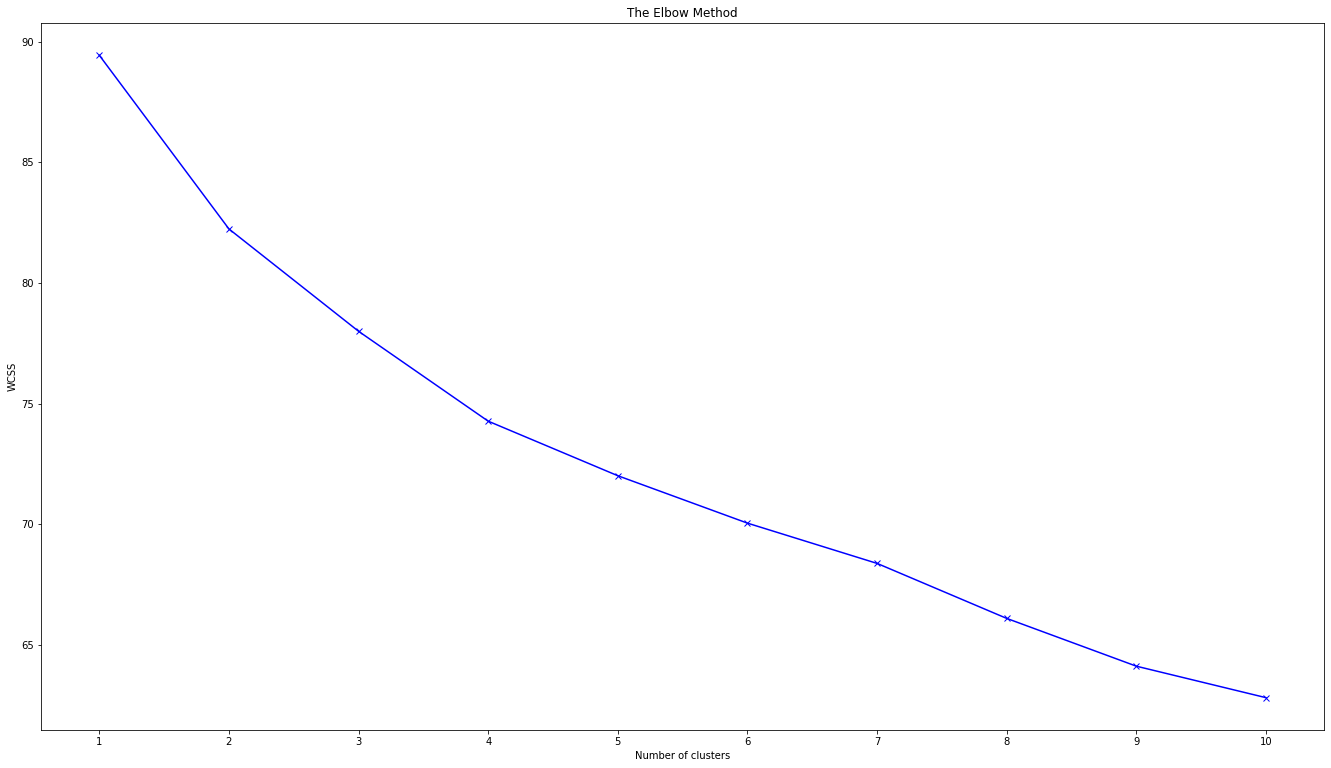

In [14]:
# plotting Within-Cluster-Sum-of-Squares (WCSS)
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (23,13)
plt.plot(range(1,11),wcss, 'bx-')
plt.title("The Elbow Method")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.xticks(range(1,11))
plt.show()

In [15]:
# Number of clusters been assigned to as the curve deflats from 4 in elbow polt
kmeans = KMeans(n_clusters=4,verbose = 0)
kmeans.fit(X)

KMeans(n_clusters=4)

finding cluster centroids and most common words

In [16]:
order_centroids = kmeans.cluster_centers_.argsort()[:,::-1]
words = vectorize.get_feature_names()

In [17]:
print("Top terms per cluster: ")
for i in range(4):
    word_list=[]
    print("Cluster %d:"%i)
    for ind in order_centroids[i,:15]:
        word_list.append(words[ind])
    print(word_list)

Top terms per cluster: 
Cluster 0:
['holmes', 'indoor', 'european', 'record', 'second', 'best', 'birmingham', 'championship', 'jump', 'francis', 'final', 'lewis', 'mark', 'gold', 'britain']
Cluster 1:
['kenteris', 'greek', 'iaaf', 'thanou', 'test', 'drug', 'charge', 'tribunal', 'athens', 'federation', 'missing', 'olympics', 'doping', 'decision', 'sprinter']
Cluster 2:
['cross', 'marathon', 'race', 'country', 'radcliffe', 'london', 'chepkemei', 'km', 'yelling', 'paula', 'team', 'run', 'event', 'great', 'york']
Cluster 3:
['conte', 'balco', 'collins', 'drug', 'jones', 'doping', 'steroid', 'performance', 'enhancing', 'victor', 'banned', 'federal', 'marion', 'case', 'agency']


### similarity Recommendation

In [18]:
# product of two vectors shares more similar information
similarity = np.dot(X[0],np.transpose(X))
x = np.array(similarity.toarray()[0])
print(df_news['text'][0])
print('\nsimiliar papers:')
print('\n'.join(df_news['text'].loc[np.argsort(x)[-7:-2]]))

McIlroy wins 800m indoor title
James McIlroy motored to the AAA's Indoor 800m title in Sheffied on Sunday in a time of one minute, 47.97 seconds.
The Larne athlete dominated the race from start to finish although he had to hold off a late challenge from Welshman Jimmy Watkins in the final 100 metres. "I had to go out and go through all the gears before the Europeans and I won't run again until then," said McIlroy. ''I though if I got lucky I'd get close to the British record but I blew up in the end.'' McIlroy has been in superb form at the start of the season and will now start his build-up for the European Indoors at Madrid on 4-6 March. Meanwhile, Paul Brizzel and Anna Boyle reached the semi-finals of the 60m hurdles with Boyle setting a season's best of 7.48. In the women's 60m final, Ailis McSweeney broke Michelle Carroll's long-standing Irish record by clocking 7.37 which left her in third place. David Gillick showed that he is a genuine medal contender in the European Indoor Cha

### Topic modeling

In [19]:
# Non-Negative Matrix Factorization (NMF)
from sklearn.decomposition import NMF

nmf  = NMF(n_components = 4)
nmf.fit(X)
for i in range(0,4):
    word_list=[]
    print("Topic%d:"% i)
    for j in nmf.components_.argsort()[i,-8:-1]:
        word_list.append(words[j])
    print(word_list)

Topic0:
['jump', 'birmingham', 'record', 'best', 'second', 'european', 'holmes']
Topic1:
['tribunal', 'drug', 'charge', 'iaaf', 'test', 'thanou', 'greek']
Topic2:
['paula', 'london', 'chepkemei', 'race', 'country', 'radcliffe', 'cross']
Topic3:
['victor', 'steroid', 'collins', 'doping', 'drug', 'jones', 'balco']


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


# Intra class Clustering for cricket class

## Data gathering and preprocessing

Reading and transpose of files in the specified path using csv, pandas and glob

In [20]:
def read_file(main_df, category):
    for filename in glob.glob('/Users/srirambharadwaj/Downloads/bbcsport/cricket' + '/*'):
        df = pd.read_csv(filename, sep = "\n", header = None, quoting=csv.QUOTE_NONE)
        df = df.transpose()
        df['text']= df.apply(lambda x: '\n'.join(x.dropna().astype(str)),axis=1)
        df = df.drop(df.columns[:-1], axis=1)
        df['label'] = category
        main_df = pd.concat([main_df,df],ignore_index=True)
    return main_df

Making use of Data frame to store the data and lablelling/ Data exploration

In [21]:
df_news= pd.DataFrame(columns=['text','label'])
list = ['cricket']

for genre in list:
    df_news = read_file(df_news, genre)

df_news.head()

,text,label
0,"Kumble breaks Kapil's record\nFirst Test, Dhak...",cricket
1,"Aussies tighten grip\nFirst Test, Perth, day t...",cricket
2,Vaughan ready for South Africa\nSkipper Michae...,cricket
3,World XI triumph in tsunami match\nTsunami App...,cricket
4,Shoaib ruled out of Test series\nFast bowler S...,cricket


In [22]:
df_news.shape

(124, 2)

In [23]:
df_news.info

<bound method DataFrame.info of                                                   text    label
0    Kumble breaks Kapil's record\nFirst Test, Dhak...  cricket
1    Aussies tighten grip\nFirst Test, Perth, day t...  cricket
2    Vaughan ready for South Africa\nSkipper Michae...  cricket
3    World XI triumph in tsunami match\nTsunami App...  cricket
4    Shoaib ruled out of Test series\nFast bowler S...  cricket
..                                                 ...      ...
119  Scotland take small step into the big time\nTh...  cricket
120  Australia dominate India\nThird Test, Nagpur, ...  cricket
121  England hopeful over Jones\nEngland are hopefu...  cricket
122  Union to contest Vaughan penalty\nThe hefty fi...  cricket
123  Australia take control\nThird Test, Sydney, da...  cricket

[124 rows x 2 columns]>

In [24]:
# Calling function text_processor
news_corpus = []
for sent in df_news["text"]:
    sent_clean = text_processor(sent)
    news_corpus.append(sent_clean)

In [25]:
len(news_corpus)

124

## TF-IDF vectorize

In [26]:
# TF-IDF are word frequency scores that try to highlight words that are more interesting
X = vectorize.fit_transform(news_corpus)
y = df_news.iloc[:,1].values

In [27]:
X.shape

(124, 892)

## KMean for clustering

In [28]:
# An ideal way to figure out the right number of clusters would be to calculate the Within-Cluster-Sum-of-Squares (WCSS)
from sklearn.cluster import KMeans

wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=10,random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

### elbow method to decide cluster number

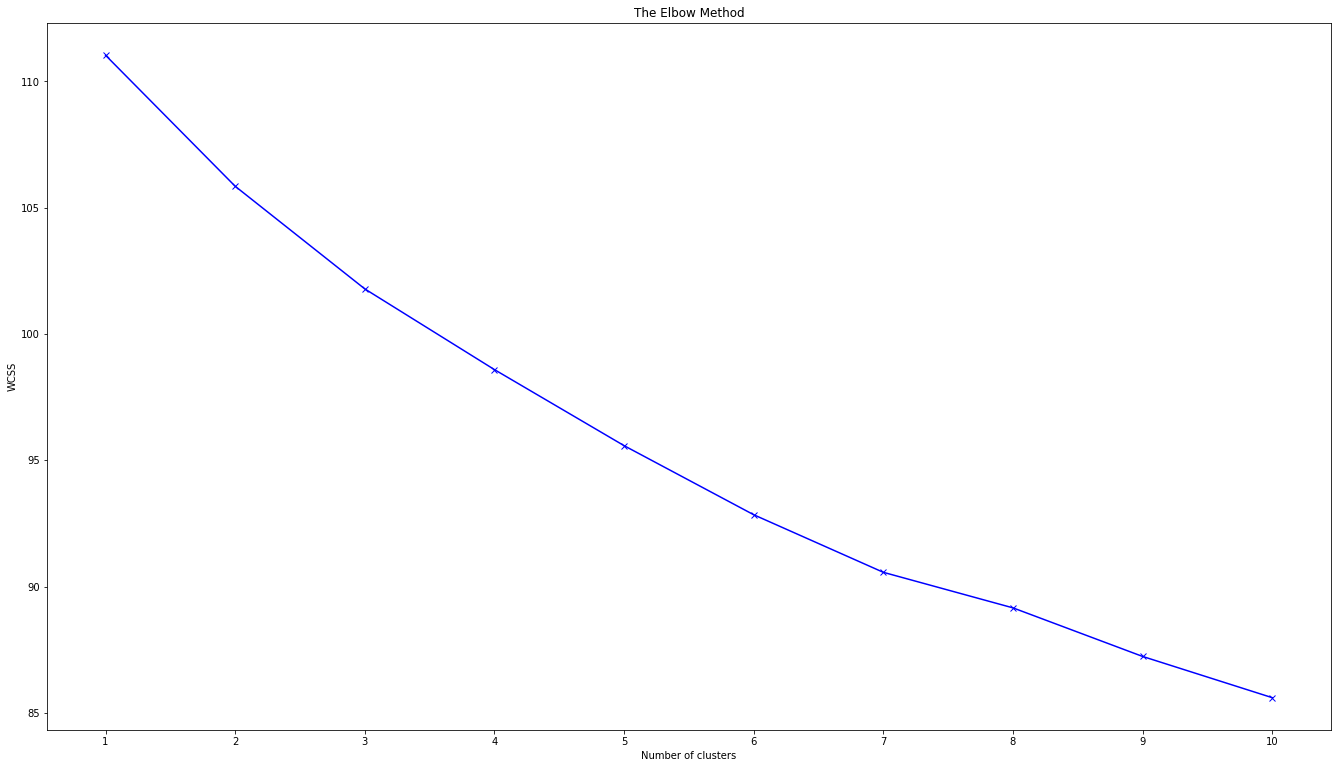

In [29]:
# plotting Within-Cluster-Sum-of-Squares (WCSS)
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (23,13)
plt.plot(range(1,11),wcss, 'bx-')
plt.title("The Elbow Method")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.xticks(range(1,11))
plt.show()

In [30]:
# Number of clusters been assigned to as the curve deflats from 7 in Elbow polt
kmeans = KMeans(n_clusters=7,verbose = 0)
kmeans.fit(X)

KMeans(n_clusters=7)

finding cluster centroids and most common words

In [31]:
order_centroids = kmeans.cluster_centers_.argsort()[:,::-1]
words = vectorize.get_feature_names()

In [32]:
print("Top terms per cluster: ")
for i in range(7):
    word_list=[]
    print("Cluster %d:"%i)
    for ind in order_centroids[i,:15]:
        word_list.append(words[ind])
    print(word_list)

Top terms per cluster: 
Cluster 0:
['zealand', 'wilson', 'tuffey', 'new', 'australia', 'bracewell', 'marshall', 'mccullum', 'vettori', 'lee', 'ponting', 'harbhajan', 'fleming', 'chris', 'cairn']
Cluster 1:
['australia', 'pakistan', 'run', 'langer', 'ponting', 'ball', 'gillespie', 'warne', 'shane', 'xi', 'mohammad', 'gilchrist', 'younis', 'clarke', 'ul']
Cluster 2:
['sri', 'lanka', 'jayasuriya', 'muralitharan', 'zealand', 'new', 'lankan', 'played', 'law', 'woman', 'world', 'tour', 'icc', 'coach', 'cup']
Cluster 3:
['england', 'vaughan', 'south', 'africa', 'jones', 'strauss', 'ball', 'andrew', 'boje', 'flintoff', 'trescothick', 'pietersen', 'smith', 'ntini', 'zimbabwe']
Cluster 4:
['pakistan', 'india', 'board', 'tour', 'president', 'icc', 'shoaib', 'woolmer', 'court', 'practice', 'think', 'indian', 'khan', 'indie', 'west']
Cluster 5:
['england', 'county', 'streak', 'competition', 'international', 'future', 'player', 'year', 'ecb', 'zimbabwe', 'trophy', 'playing', 'tour', 'south', 'africa

### similarity Recommendation

In [33]:
# product of two vectors shares more similar information
similarity = np.dot(X[0],np.transpose(X))
x = np.array(similarity.toarray()[0])
print(df_news['text'][0])
print('\nsimiliar papers:')
print('\n'.join(df_news['text'].loc[np.argsort(x)[-7:-2]]))

Kumble breaks Kapil's record
First Test, Dhaka, day one (stumps): Bangladesh 184 all out v India
Kumble overtook the mark set by Kapil Dev when he had Mohammad Rafique lbw. And he followed up with a wicket next ball before Bangladesh were bowled out for 184 in 58 overs in Dhaka. After the first session was lost to rain, Irfan Pathan took five wickets to reduce the hosts to 106-7 before Mohammad Ashraful dug in. Ashraful ended unbeaten on 60, having hit six fours and faced 135 balls. Kumble had a chance of a hat-trick after removing Tapash Baisya via a catch at first slip but Mashrafe Mortaza safely defended the fifth ball of his 12th over. But a run out ended the innings not long afterwards.
India did not get chance to begin their reply as openers Virender Sehwag and Gautam Gambhir were immediately offered the light on stepping to the wicket. India won the toss and Pathan soon got stuck into the top order, dismissing Javed Omar lbw in his second over with one that nipped back. Nafis Iq

### Topic modeling

In [34]:
# Non-Negative Matrix Factorization (NMF)
from sklearn.decomposition import NMF

nmf  = NMF(n_components = 7)
nmf.fit(X)
for i in range(0,7):
    word_list=[]
    print("Topic%d:"% i)
    for j in nmf.components_.argsort()[i,-8:-1]:
        word_list.append(words[j])
    print(word_list)

Topic0:
['board', 'indie', 'west', 'year', 'england', 'tour', 'india']
Topic1:
['flintoff', 'trescothick', 'strauss', 'africa', 'south', 'jones', 'vaughan']
Topic2:
['new', 'zealand', 'jayasuriya', 'lankan', 'muralitharan', 'icc', 'lanka']
Topic3:
['wilson', 'vettori', 'hayden', 'new', 'ponting', 'lee', 'australia']
Topic4:
['mohammad', 'ashraful', 'pathan', 'kumble', 'rafique', 'ganguly', 'india']
Topic5:
['tatenda', 'south', 'africa', 'matsikenyeri', 'rogers', 'taibu', 'streak']
Topic6:
['younis', 'kaneria', 'shoaib', 'khan', 'langer', 'ul', 'inzamam']


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


# Intra class Clustering for football class

## Data gathering and preprocessing

Reading and transpose of files in the specified path using csv, pandas and glob

In [35]:
def read_file(main_df, category):
    for filename in glob.glob('/Users/srirambharadwaj/Downloads/bbcsport/football' + '/*'):
        df = pd.read_csv(filename, sep = "\n", header = None, quoting=csv.QUOTE_NONE)
        df = df.transpose()
        df['text']= df.apply(lambda x: '\n'.join(x.dropna().astype(str)),axis=1)
        df = df.drop(df.columns[:-1], axis=1)
        df['label'] = category
        main_df = pd.concat([main_df,df],ignore_index=True)
    return main_df

Making use of Data frame to store the data and lablelling/ Data exploration

In [36]:
df_news= pd.DataFrame(columns=['text','label'])
list = ['football']

for genre in list:
    df_news = read_file(df_news, genre)

df_news.head()

,text,label
0,Van Nistelrooy hungry for return\nManchester U...,football
1,Reyes tricked into Real admission\nJose Antoni...,football
2,Adriano's Chelsea link rejected\nAdriano's age...,football
3,Owen determined to stay in Madrid\nEngland for...,football
4,Souness backs Smith for Scotland\nGraeme Soune...,football


In [37]:
df_news.shape

(265, 2)

In [38]:
df_news.info

<bound method DataFrame.info of                                                   text     label
0    Van Nistelrooy hungry for return\nManchester U...  football
1    Reyes tricked into Real admission\nJose Antoni...  football
2    Adriano's Chelsea link rejected\nAdriano's age...  football
3    Owen determined to stay in Madrid\nEngland for...  football
4    Souness backs Smith for Scotland\nGraeme Soune...  football
..                                                 ...       ...
260  QPR keeper Day heads for Preston\nQueens Park ...  football
261  Stuart joins Norwich from Addicks\nNorwich hav...  football
262  Brentford v Southampton\nGriffin Park\nTuesday...  football
263  Chelsea 3-0 Portsmouth\nDidier Drogba scored t...  football
264  Man City 1-1 Newcastle\nAlan Shearer hit his 2...  football

[265 rows x 2 columns]>

In [39]:
# Calling text_processor function for preprocessing
news_corpus = []
for sent in df_news["text"]:
    sent_clean = text_processor(sent)
    news_corpus.append(sent_clean)

In [40]:
len(news_corpus)

265

## TF-IDF vectorize

In [41]:
# TF-IDF are word frequency scores that try to highlight words that are more interesting
X = vectorize.fit_transform(news_corpus)
y = df_news.iloc[:,1].values

In [42]:
X.shape

(265, 1439)

## KMean for clustering

In [43]:
# An ideal way to figure out the right number of clusters would be to calculate the Within-Cluster-Sum-of-Squares (WCSS)
from sklearn.cluster import KMeans

wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=10,random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

### elbow method to decide cluster number

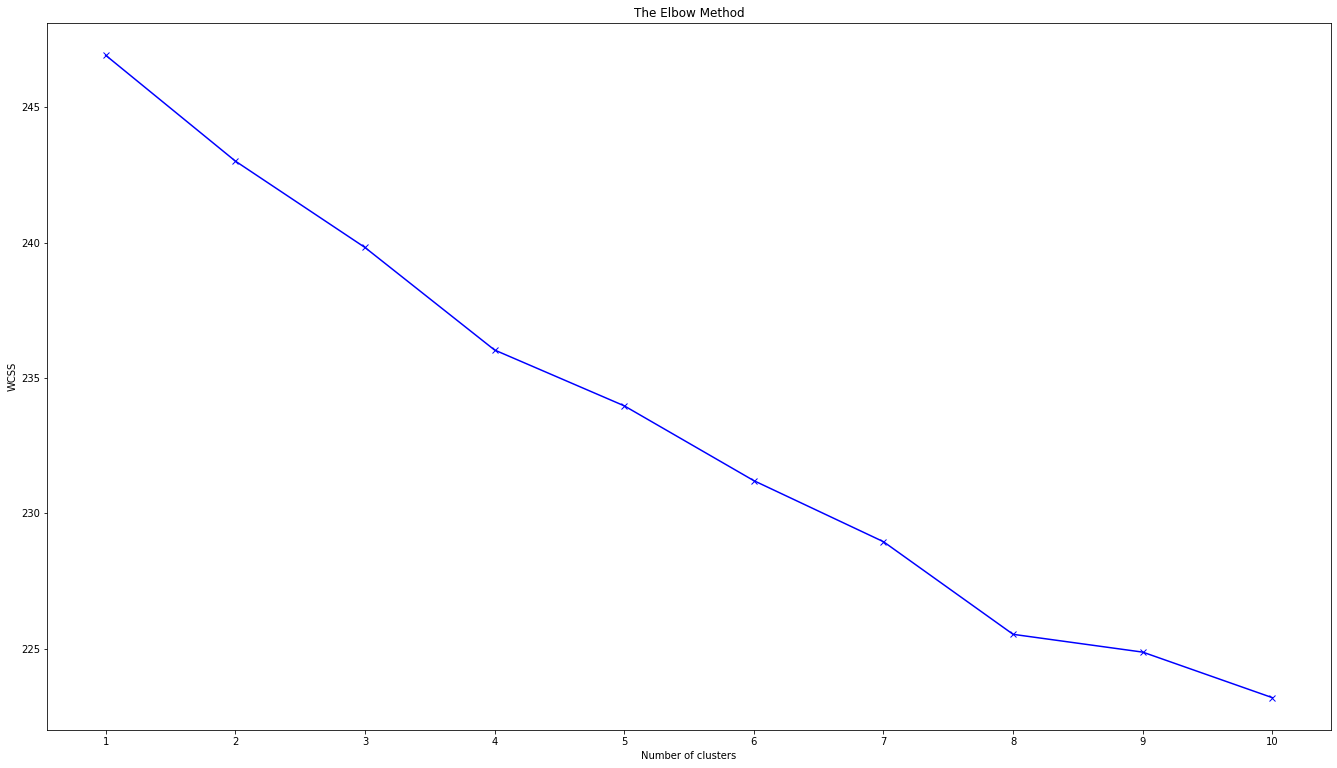

In [44]:
# plotting Within-Cluster-Sum-of-Squares (WCSS)
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (23,13)
plt.plot(range(1,11),wcss, 'bx-')
plt.title("The Elbow Method")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.xticks(range(1,11))
plt.show()

In [45]:
# Number of clusters been assigned to as the curve deflats from 8 in Elbow polt
kmeans = KMeans(n_clusters=8,verbose = 0)
kmeans.fit(X)

KMeans()

finding cluster centroids and most common words

In [46]:
order_centroids = kmeans.cluster_centers_.argsort()[:,::-1]
words = vectorize.get_feature_names()

In [47]:
print("Top terms per cluster: ")
for i in range(8):
    word_list=[]
    print("Cluster %d:"%i)
    for ind in order_centroids[i,:15]:
        word_list.append(words[ind])
    print(word_list)

Top terms per cluster: 
Cluster 0:
['fifa', 'football', 'world', 'brazil', 'blatter', 'technology', 'african', 'award', 'dutch', 'president', 'smith', 'goal', 'cup', 'south', 'line']
Cluster 1:
['chelsea', 'mourinho', 'league', 'fa', 'cup', 'barcelona', 'match', 'injury', 'champion', 'arsenal', 'referee', 'season', 'final', 'united', 'following']
Cluster 2:
['wenger', 'arsenal', 'souness', 'contract', 'new', 'want', 'bellamy', 'manager', 'think', 'deal', 'team', 'newcastle', 'play', 'arsene', 'stay']
Cluster 3:
['real', 'madrid', 'beckham', 'owen', 'spain', 'england', 'spanish', 'aragones', 'happy', 'chelsea', 'everton', 'barcelona', 'going', 'bernabeu', 'people']
Cluster 4:
['united', 'ferguson', 'manchester', 'ranger', 'good', 'tie', 'manager', 'smith', 'got', 'league', 'come', 'alex', 'play', 'nistelrooy', 'team']
Cluster 5:
['minute', 'goal', 'ball', 'shot', 'sub', 'second', 'half', 'used', 'yard', 'lead', 'united', 'cross', 'home', 'free', 'chance']
Cluster 6:
['israel', 'ireland'

### similarity Recommendation

In [48]:
# product of two vectors shares more similar information
similarity = np.dot(X[0],np.transpose(X))
x = np.array(similarity.toarray()[0])
print(df_news['text'][0])
print('\nsimiliar papers:')
print('\n'.join(df_news['text'].loc[np.argsort(x)[-7:-2]]))

Van Nistelrooy hungry for return
Manchester United striker Ruud van Nistelrooy said he was "hungry to play" as he returned to training on Tuesday.
The Dutch striker, 28, is closing in on a comeback after nearly three months out with an Achilles injury. "I can't wait to get back training and meet up with my team-mates again," he told the Daily Mirror newspaper. "I'm ahead of schedule and I've made good progress with my physio in Holland. I have been away from United for a long time, but I'm fit again." United boss Sir Alex Ferguson hinted at a return for Van Nistelrooy in the FA Cup fifth round tie at Everton on Saturday. He said: "There is a chance he could be involved at Everton but we'll just have to see how he comes through training." United did not lose any of the 14 games in which Van Nistelrooy was involved before his injury - although their form has remained good since he was sidelined. Their 2-0 derby win at Manchester City on Sunday made it 13 wins in 15 league games.
However,

### Topic modeling

In [49]:
# Non-Negative Matrix Factorization (NMF)
from sklearn.decomposition import NMF

nmf  = NMF(n_components = 8)
nmf.fit(X)
for i in range(0,8):
    word_list=[]
    print("Topic%d:"% i)
    for j in nmf.components_.argsort()[i,-8:-1]:
        word_list.append(words[j])
    print(word_list)

Topic0:
['everton', 'nistelrooy', 'southampton', 'west', 'manchester', 'tie', 'ferguson']
Topic1:
['lead', 'sub', 'second', 'ball', 'half', 'shot', 'goal']
Topic2:
['want', 'morientes', 'anfield', 'steven', 'parry', 'benitez', 'gerrard']
Topic3:
['robben', 'carling', 'jose', 'champion', 'league', 'barcelona', 'mourinho']
Topic4:
['bernabeu', 'barcelona', 'spanish', 'england', 'owen', 'beckham', 'madrid']
Topic5:
['new', 'henry', 'gunner', 'almunia', 'arsene', 'lehmann', 'wenger']
Topic6:
['window', 'transfer', 'graeme', 'newcastle', 'celtic', 'ranger', 'bellamy']
Topic7:
['final', 'team', 'play', 'uefa', 'cup', 'world', 'football']


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


# Intra class Clustering for rugby class

## Data gathering and preprocessing

Reading and transpose of files in the specified path using csv, pandas and glob

In [50]:
def read_file(main_df, category):
    for filename in glob.glob('/Users/srirambharadwaj/Downloads/bbcsport/rugby' + '/*'):
        df = pd.read_csv(filename, sep = "\n", header = None, quoting=csv.QUOTE_NONE)
        df = df.transpose()
        df['text']= df.apply(lambda x: '\n'.join(x.dropna().astype(str)),axis=1)
        df = df.drop(df.columns[:-1], axis=1)
        df['label'] = category
        main_df = pd.concat([main_df,df],ignore_index=True)
    return main_df

Making use of Data frame to store the data and lablelling/ Data exploration

In [51]:
df_news= pd.DataFrame(columns=['text','label'])
list = ['rugby']

for genre in list:
    df_news = read_file(df_news, genre)

df_news.head()

,text,label
0,England coach faces rap after row\nEngland coa...,rugby
1,Wales want rugby league training\nWales could ...,rugby
2,O'Driscoll/Gregan lead Aid stars\nIreland's Br...,rugby
3,Hurter flees Falcons nest for SA\nNewcastle ti...,rugby
4,Dawson wins England squad recall\nWasps scrum-...,rugby


In [52]:
df_news.shape

(147, 2)

In [53]:
df_news.info

<bound method DataFrame.info of                                                   text  label
0    England coach faces rap after row\nEngland coa...  rugby
1    Wales want rugby league training\nWales could ...  rugby
2    O'Driscoll/Gregan lead Aid stars\nIreland's Br...  rugby
3    Hurter flees Falcons nest for SA\nNewcastle ti...  rugby
4    Dawson wins England squad recall\nWasps scrum-...  rugby
..                                                 ...    ...
142  Stevens named in England line-up\nEngland have...  rugby
143  Umaga ready for Lions\nAll Blacks captain Tama...  rugby
144  Funding cut hits Wales Students\nThe Wales Stu...  rugby
145  Dallaglio his own man to the end\nControversy ...  rugby
146  South Africa sweep top awards\nSouth Africa's ...  rugby

[147 rows x 2 columns]>

In [54]:
# Calling text_processor for preprocessing
news_corpus = []
for sent in df_news["text"]:
    sent_clean = text_processor(sent)
    news_corpus.append(sent_clean)

In [55]:
len(news_corpus)

147

## TF-IDF vectorize

In [56]:
# TF-IDF are word frequency scores that try to highlight words that are more interesting
X = vectorize.fit_transform(news_corpus)
y = df_news.iloc[:,1].values

In [57]:
X.shape

(147, 1005)

## KMean for clustering

In [58]:
# An ideal way to figure out the right number of clusters would be to calculate the Within-Cluster-Sum-of-Squares (WCSS)
from sklearn.cluster import KMeans

wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=10,random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

### elbow method to decide cluster number

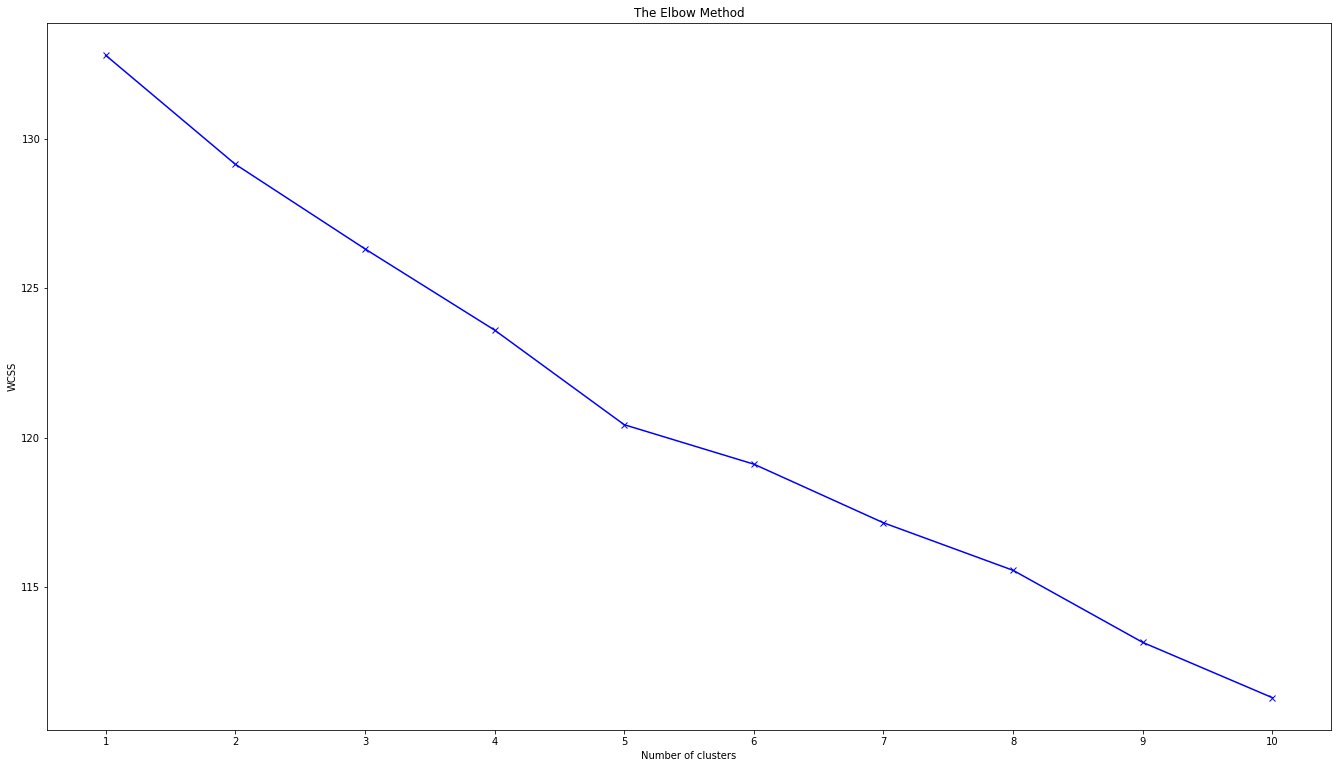

In [59]:
# plotting Within-Cluster-Sum-of-Squares (WCSS)
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (23,13)
plt.plot(range(1,11),wcss, 'bx-')
plt.title("The Elbow Method")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.xticks(range(1,11))
plt.show()

In [60]:
# Number of clusters been assigned to as the curve deflats from 5 in Elbow polt
kmeans = KMeans(n_clusters=5,verbose = 0)
kmeans.fit(X)

KMeans(n_clusters=5)

finding cluster centroids and most common words

In [61]:
order_centroids = kmeans.cluster_centers_.argsort()[:,::-1]
words = vectorize.get_feature_names()

In [62]:
print("Top terms per cluster: ")
for i in range(5):
    word_list=[]
    print("Cluster %d:"%i)
    for ind in order_centroids[i,:15]:
        word_list.append(words[ind])
    print(word_list)

Top terms per cluster: 
Cluster 0:
['wale', 'williams', 'ruddock', 'jones', 'italy', 'thomas', 'henson', 'france', 'scotland', 'welsh', 'cardiff', 'dragon', 'gareth', 'luscombe', 'team']
Cluster 1:
['lion', 'tour', 'zealand', 'new', 'woodward', 'dallaglio', 'black', 'match', 'world', 'captain', 'wilkinson', 'june', 'international', 'test', 'clive']
Cluster 2:
['robinson', 'bath', 'leicester', 'gloucester', 'injury', 'wasp', 'tait', 'tindall', 'dawson', 'week', 'sale', 'andy', 'vickery', 'squad', 'wale']
Cluster 3:
['ireland', 'try', 'france', 'gara', 'penalty', 'sullivan', 'ball', 'laporte', 'minute', 'irish', 'second', 'scotland', 'hodgson', 'italy', 'connor']
Cluster 4:
['saracen', 'cup', 'edinburgh', 'club', 'union', 'season', 'seven', 'league', 'south', 'international', 'decision', 'match', 'director', 'world', 'final']


### similarity Recommendation

In [63]:
# product of two vectors shares more similar information
similarity = np.dot(X[0],np.transpose(X))
x = np.array(similarity.toarray()[0])
print(df_news['text'][0])
print('\nsimiliar papers:')
print('\n'.join(df_news['text'].loc[np.argsort(x)[-7:-2]]))

England coach faces rap after row
England coach Andy Robinson is facing disciplinary action after criticising referee Jonathan Kaplan in his side's Six Nations defeat to Ireland.
The Rugby Football Union (RFU) will investigate Robinson after deciding not to lodge a complaint against Kaplan. Robinson may even have to apologise for his comments in order to avoid sanction from the International Rugby Board. Robinson had said he was "livid" about Kaplan's decisions on Saturday to disallow two England "tries." The England coach went on to claim that "only one side was refereed".
After reviewing tapes of the match, the RFU decided not to formally complain to the IRB over the standard of Kaplan's refereeing. Instead the RFU said in a statement they would, "set out any concerns the England team management may have in a confidential manner".
An IRB spokesman said on the matter: "We take all breaches of the code very seriously. "Should the RFU resolve the issue to our satisfaction, as happened l

### Topic modeling

In [64]:
# Non-Negative Matrix Factorization (NMF)
from sklearn.decomposition import NMF

nmf  = NMF(n_components = 5)
nmf.fit(X)
for i in range(0,5):
    word_list=[]
    print("Topic%d:"% i)
    for j in nmf.components_.argsort()[i,-8:-1]:
        word_list.append(words[j])
    print(word_list)

Topic0:
['club', 'andy', 'wasp', 'wilkinson', 'injury', 'leicester', 'bath']
Topic1:
['ball', 'driscoll', 'italy', 'minute', 'penalty', 'gara', 'try']
Topic2:
['welsh', 'italy', 'henson', 'thomas', 'ruddock', 'jones', 'williams']
Topic3:
['cup', 'dallaglio', 'world', 'woodward', 'tour', 'zealand', 'new']
Topic4:
['julien', 'michalak', 'yannick', 'harinordoquy', 'biarritz', 'laporte', 'france']


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


# Intra class Clustering for tennis class

## Data gathering and preprocessing

Reading and transpose of files in the specified path using csv, pandas and glob

In [65]:
def read_file(main_df, category):
    for filename in glob.glob('/Users/srirambharadwaj/Downloads/bbcsport/tennis' + '/*'):
        df = pd.read_csv(filename, sep = "\n", header = None, quoting=csv.QUOTE_NONE)
        df = df.transpose()
        df['text']= df.apply(lambda x: '\n'.join(x.dropna().astype(str)),axis=1)
        df = df.drop(df.columns[:-1], axis=1)
        df['label'] = category
        main_df = pd.concat([main_df,df],ignore_index=True)
    return main_df

Making use of Data frame to store the data and lablelling/ Data exploration

In [66]:
df_news= pd.DataFrame(columns=['text','label'])
list = ['tennis']

for genre in list:
    df_news = read_file(df_news, genre)

df_news.head()

,text,label
0,Edgy Agassi struggles past Dent\nAndre Agassi ...,tennis
1,Roche 'turns down Federer offer'\nAustralian t...,tennis
2,Classy Henman makes winning start\nTim Henman ...,tennis
3,Sharapova overcomes tough Molik\nWimbledon cha...,tennis
4,Moya emotional after Davis Cup win\nCarlos Moy...,tennis


In [67]:
df_news.shape

(100, 2)

In [68]:
df_news.info

<bound method DataFrame.info of                                                  text   label
0   Edgy Agassi struggles past Dent\nAndre Agassi ...  tennis
1   Roche 'turns down Federer offer'\nAustralian t...  tennis
2   Classy Henman makes winning start\nTim Henman ...  tennis
3   Sharapova overcomes tough Molik\nWimbledon cha...  tennis
4   Moya emotional after Davis Cup win\nCarlos Moy...  tennis
..                                                ...     ...
95  Capriati out of Australian Open\nJennifer Capr...  tennis
96  Henin-Hardenne beaten on comeback\nJustine Hen...  tennis
97  Moya sidesteps Davis Cup in 2005\nCarlos Moya ...  tennis
98  Australia miss Molik for Fed Cup\nAustralia wi...  tennis
99  Rusedski forced out in Marseille\nGreg Rusedsk...  tennis

[100 rows x 2 columns]>

In [69]:
# Calling text_processor for preprocessing
news_corpus = []
for sent in df_news["text"]:
    sent_clean = text_processor(sent)
    news_corpus.append(sent_clean)

In [70]:
len(news_corpus)

100

## TF-IDF vectorize

In [71]:
# TF-IDF are word frequency scores that try to highlight words that are more interesting
X = vectorize.fit_transform(news_corpus)
y = df_news.iloc[:,1].values

In [72]:
X.shape

(100, 501)

## KMean for clustering

In [73]:
# An ideal way to figure out the right number of clusters would be to calculate the Within-Cluster-Sum-of-Squares (WCSS)
from sklearn.cluster import KMeans

wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=10,random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

### elbow method to decide cluster number

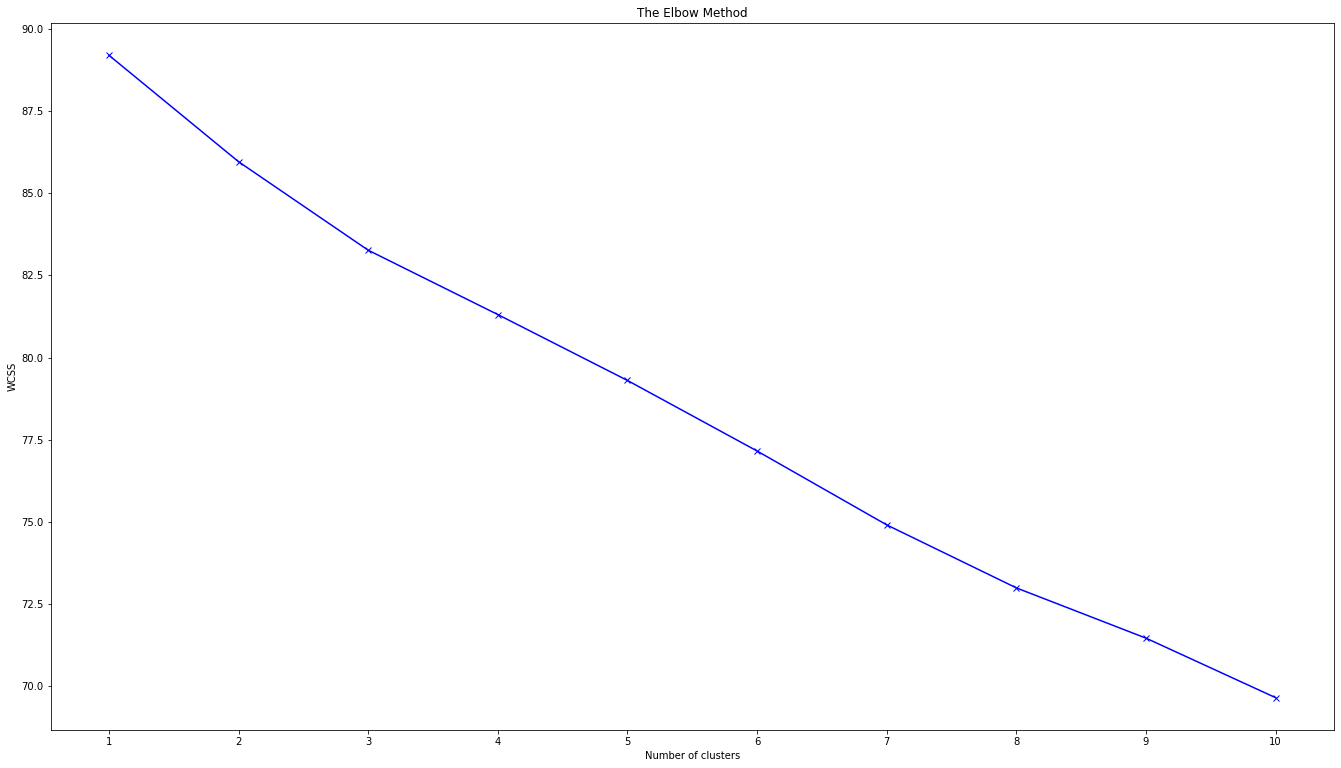

In [74]:
# plotting Within-Cluster-Sum-of-Squares (WCSS)
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (23,13)
plt.plot(range(1,11),wcss, 'bx-')
plt.title("The Elbow Method")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.xticks(range(1,11))
plt.show()

In [75]:
# Number of clusters been assigned to as the curve deflats from 3 in Elbow polt
kmeans = KMeans(n_clusters=3,verbose = 0)
kmeans.fit(X)

KMeans(n_clusters=3)

finding cluster centroids and most common words

In [76]:
order_centroids = kmeans.cluster_centers_.argsort()[:,::-1]
words = vectorize.get_feature_names()

In [77]:
print("Top terms per cluster: ")
for i in range(3):
    word_list=[]
    print("Cluster %d:"%i)
    for ind in order_centroids[i,:15]:
        word_list.append(words[ind])
    print(word_list)

Top terms per cluster: 
Cluster 0:
['henman', 'federer', 'murray', 'rusedski', 'coach', 'tennis', 'ljubicic', 'cup', 'player', 'davis', 'britain', 'roger', 'tim', 'british', 'roddick']
Cluster 1:
['roddick', 'seed', 'agassi', 'moya', 'safin', 'hewitt', 'nadal', 'beat', 'dent', 'break', 'johansson', 'american', 'spain', 'davis', 'title']
Cluster 2:
['williams', 'davenport', 'woman', 'round', 'mirza', 'champion', 'australian', 'clijsters', 'injury', 'title', 'wimbledon', 'serena', 'martinez', 'hantuchova', 'grand']


### similarity Recommendation

In [78]:
# product of two vectors shares more similar information
similarity = np.dot(X[0],np.transpose(X))
x = np.array(similarity.toarray()[0])
print(df_news['text'][0])
print('\nsimiliar papers:')
print('\n'.join(df_news['text'].loc[np.argsort(x)[-7:-2]]))

Edgy Agassi struggles past Dent
Andre Agassi put in an erratic display before edging into the fourth round of the Australian Open with victory over Taylor Dent.
The 34-year-old American, seeded eighth, made a poor start, dropping serve early on and later needing two chances to serve out the set. Having secured the lead, Agassi still failed to take control as both players forced a succession of breaks. But Agassi won the tie-break before wrapping up a 7-5 7-6 (7-3) 6-1 win. Fourth seed
survived an injury scare as he battled past Mario Ancic 6-4 3-6 6-3 6-4. The Russian turned his right ankle in the third game of the fourth set and called for treatment immediately. But he showed no sign of the problem when he returned to the court to wrap up victory in two hours 45 minutes.
Ancic, Wimbledon semi-finalist in 2004, looked set to push Safin all the way when he took the second set but Safin raised his game to sink the Croatian. Safin said he was trying to keep his temper under control at thi

### Topic modeling

In [79]:
# Non-Negative Matrix Factorization (NMF)
from sklearn.decomposition import NMF

nmf  = NMF(n_components = 3)
nmf.fit(X)
for i in range(0,3):
    word_list=[]
    print("Topic%d:"% i)
    for j in nmf.components_.argsort()[i,-8:-1]:
        word_list.append(words[j])
    print(word_list)

Topic0:
['clijsters', 'mirza', 'injury', 'australian', 'champion', 'woman', 'davenport']
Topic1:
['henman', 'spain', 'team', 'murray', 'roddick', 'moya', 'davis']
Topic2:
['beat', 'break', 'ljubicic', 'roddick', 'henman', 'federer', 'agassi']


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


#  Clustering athletics, cricket, football, rugby, tennis

## Data gathering and preprocessing

In [80]:
def read_file(main_df, category):
    for filename in glob.glob('/Users/srirambharadwaj/Downloads/bbcsport/'+ category + '/*'):
        df = pd.read_csv(filename, sep = "\n", header = None, quoting=csv.QUOTE_NONE)
        df = df.transpose()
        df["text"]= df.apply(lambda x: '\n'.join(x.dropna().astype(str)),axis=1)
        df = df.drop(df.columns[:-1], axis=1)
        df["label"] = category
        main_df = pd.concat([main_df,df],ignore_index=True)
    return main_df

In [81]:
df_news= pd.DataFrame(columns=['text','label'])
list = ['athletics','cricket', 'football','rugby','tennis']

for genre in list:
    df_news = read_file(df_news, genre)

df_news.head()

,text,label
0,McIlroy wins 800m indoor title\nJames McIlroy ...,athletics
1,Pavey focuses on indoor success\nJo Pavey will...,athletics
2,Greek pair set for hearing\nKostas Kenteris an...,athletics
3,Freeman considers return to track\nFormer Olym...,athletics
4,Event devised to nurture athletes\nUK Athletic...,athletics


In [82]:
df_news.shape

(737, 2)

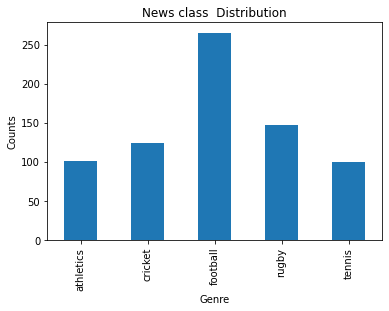

In [83]:
# Plotiing the no.of elments inside each class
import matplotlib.pyplot as plt

%matplotlib inline

df_news.groupby('label').label.count().plot.bar()
plt.title("News class  Distribution")
plt.xlabel('Genre')
plt.ylabel('Counts')
plt.show()

## New Method

In [84]:
from pyspark import SparkFiles
from pyspark.ml import Pipeline
from pyspark.ml.feature import *
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import col 
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
from pyspark.mllib.classification import *

sc = SparkContext.getOrCreate()
sqlCtx = SQLContext(sc)

In [85]:
for row in range(len(df_news)):
    line = df_news.iloc[row,0]
    df_news.iloc[row,0] = re.sub("[^a-zA-Z0-9]", " ", line)
    
df_news_lower = df_news.apply(lambda x: x.astype(str).str.lower())
# panda dataframe to sql dataframe Conversion
sql_news = sqlCtx.createDataFrame(df_news_lower)

regexTokenizer = RegexTokenizer(inputCol="text",
                                outputCol="words",
                                pattern="\\W")
# countTokens = udf(lambda words: len(words), IntegerType())
regexTokenized = regexTokenizer.transform(sql_news).select("words","label")

remover = StopWordsRemover(inputCol="words", outputCol="cleaned")
removed = remover.transform(regexTokenized).select("cleaned","label")

from nltk.stem import SnowballStemmer

df_removed = removed.toPandas()
stemmer = SnowballStemmer('english')
df_removed["words"] = df_removed["cleaned"].apply(lambda x: [stemmer.stem(y) for y in x])

In [86]:
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator
from os import path
%matplotlib inline

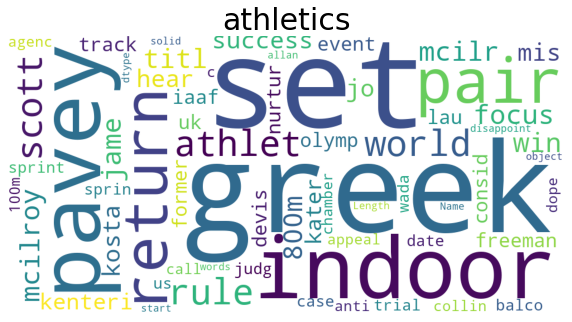

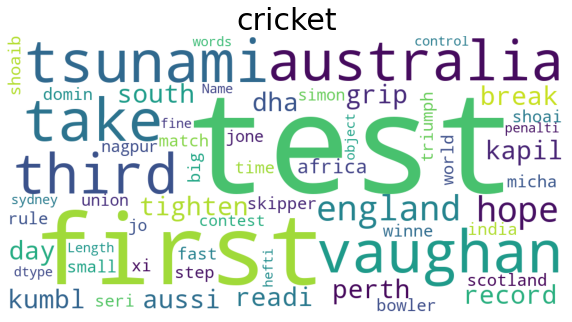

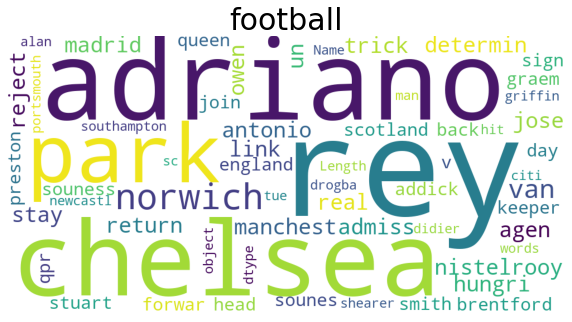

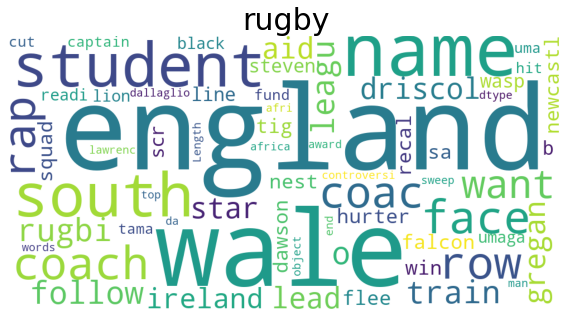

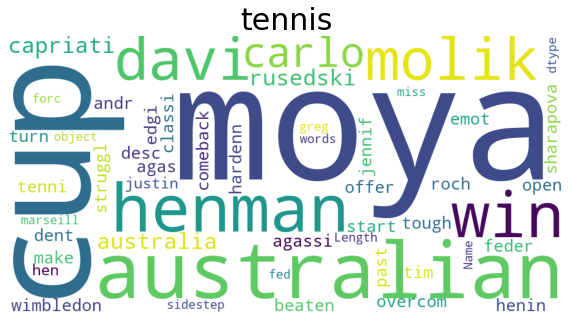

In [87]:
pol = df_removed[df_removed['label'] == 'athletics']
wordcloud = WordCloud(background_color="white", width = 1000, height = 500).generate(''.join(str(pol["words"])))
plt.figure(figsize=(10,7))
plt.imshow(wordcloud)
plt.title("athletics", fontsize=30)
plt.axis("off")
plt.show()
print("\n")
pol = df_removed[df_removed['label'] == 'cricket']
wordcloud = WordCloud(background_color="white", width = 1000, height = 500).generate(''.join(str(pol["words"])))
plt.figure(figsize=(10,7))
plt.imshow(wordcloud)
plt.title("cricket", fontsize=30)
plt.axis("off")
plt.show()
print("\n")
pol = df_removed[df_removed['label'] == 'football']
wordcloud = WordCloud(background_color="white", width = 1000, height = 500).generate(''.join(str(pol["words"])))
plt.figure(figsize=(10,7))
plt.imshow(wordcloud)
plt.title("football", fontsize=30)
plt.axis("off")
plt.show()
print("\n")
pol = df_removed[df_removed['label'] == 'rugby']
wordcloud = WordCloud(background_color="white", width = 1000, height = 500).generate(''.join(str(pol["words"])))
plt.figure(figsize=(10,7))
plt.imshow(wordcloud)
plt.title("rugby", fontsize=30)
plt.axis("off")
plt.show()
print("\n")
pol = df_removed[df_removed['label'] == 'tennis']
wordcloud = WordCloud(background_color="white", width = 1000, height = 500).generate(''.join(str(pol["words"])))
plt.figure(figsize=(10,7))
plt.imshow(wordcloud)
plt.title("tennis", fontsize=30)
plt.axis("off")
plt.show()


## Old Method

In [88]:
# Calling text_processor for preprocessing
news_corpus = []
for sent in df_news["text"]:
    sent_clean = text_processor(sent)
    news_corpus.append(sent_clean)

In [89]:
len(news_corpus)

737

## TF-IDF vectorize

In [90]:
# TF-IDF are word frequency scores that try to highlight words that are more interesting
X = vectorize.fit_transform(news_corpus)
y = df_news.iloc[:,1].values

In [91]:
X.shape

(737, 3410)

## KMean for clustering

In [92]:
# An ideal way to figure out the right number of clusters would be to calculate the Within-Cluster-Sum-of-Squares (WCSS)
from sklearn.cluster import KMeans

wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=10,random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

### elbow method to decide cluster number

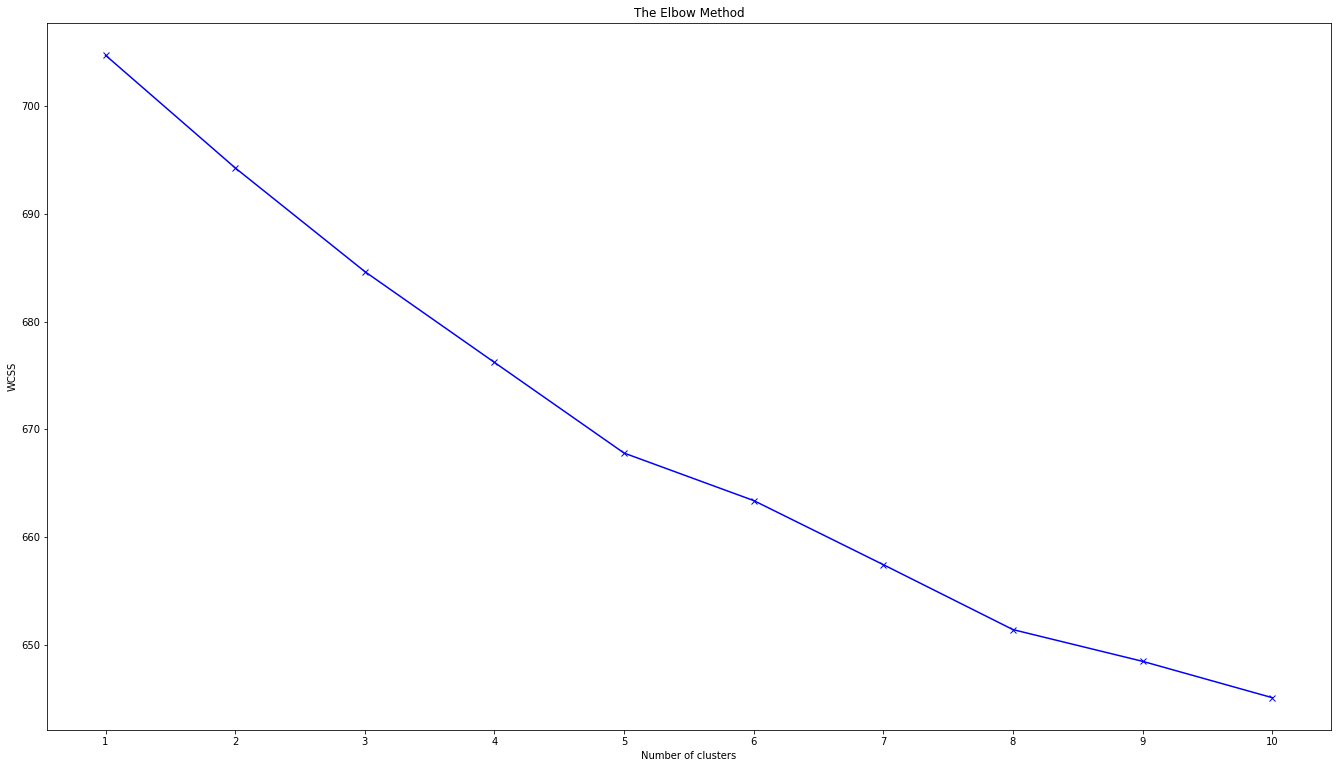

In [93]:
# plotting Within-Cluster-Sum-of-Squares (WCSS) and elbow mecthod to find the correct number of clusters
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (23,13)
plt.plot(range(1,11),wcss, 'bx-')
plt.title("The Elbow Method")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.xticks(range(1,11))
plt.show()

In [94]:
# Number of clusters been assigned to as the curve deflats at 5 and 8 in Elbow polt
kmeans = KMeans(n_clusters=8,verbose = 0)
kmeans.fit(X)

KMeans()

finding cluster centroids and most common words

In [95]:
order_centroids = kmeans.cluster_centers_.argsort()[:,::-1]
words = vectorize.get_feature_names()

In [96]:
print("Top terms per cluster: ")
for i in range(8):
    word_list=[]
    print("Cluster %d:"%i)
    for ind in order_centroids[i,:15]:
        word_list.append(words[ind])
    print(word_list)

Top terms per cluster: 
Cluster 0:
['race', 'indoor', 'olympic', 'holmes', 'world', 'european', 'record', 'marathon', 'championship', 'champion', 'britain', 'radcliffe', 'british', 'birmingham', 'athlete']
Cluster 1:
['england', 'wale', 'ireland', 'rugby', 'nation', 'france', 'robinson', 'half', 'scotland', 'try', 'lion', 'italy', 'coach', 'player', 'williams']
Cluster 2:
['pakistan', 'cricket', 'test', 'india', 'australia', 'series', 'wicket', 'sri', 'day', 'tour', 'zealand', 'bangladesh', 'match', 'run', 'lanka']
Cluster 3:
['drug', 'kenteris', 'iaaf', 'thanou', 'greek', 'doping', 'conte', 'test', 'athlete', 'balco', 'athens', 'sprinter', 'olympics', 'athletics', 'charge']
Cluster 4:
['chelsea', 'arsenal', 'mourinho', 'goal', 'league', 'liverpool', 'minute', 'premiership', 'wenger', 'united', 'cup', 'win', 'bos', 'player', 'club']
Cluster 5:
['south', 'england', 'africa', 'vaughan', 'test', 'zimbabwe', 'strauss', 'boje', 'jones', 'day', 'flintoff', 'trescothick', 'ball', 'wicket', 's

### similarity Recommendation

In [97]:
# product of two vectors shares more similar information
similarity = np.dot(X[0],np.transpose(X))
x = np.array(similarity.toarray()[0])
print(df_news['text'][0])
print('\nsimiliar papers:')
print('\n'.join(df_news['text'].loc[np.argsort(x)[-7:-2]]))

McIlroy wins 800m indoor title James McIlroy motored to the AAA s Indoor 800m title in Sheffied on Sunday in a time of one minute  47 97 seconds  The Larne athlete dominated the race from start to finish although he had to hold off a late challenge from Welshman Jimmy Watkins in the final 100 metres   I had to go out and go through all the gears before the Europeans and I won t run again until then   said McIlroy    I though if I got lucky I d get close to the British record but I blew up in the end    McIlroy has been in superb form at the start of the season and will now start his build up for the European Indoors at Madrid on 4 6 March  Meanwhile  Paul Brizzel and Anna Boyle reached the semi finals of the 60m hurdles with Boyle setting a season s best of 7 48  In the women s 60m final  Ailis McSweeney broke Michelle Carroll s long standing Irish record by clocking 7 37 which left her in third place  David Gillick showed that he is a genuine medal contender in the European Indoor Cha

### Topic modeling

In [98]:
# Non-Negative Matrix Factorization (NMF)
from sklearn.decomposition import NMF

nmf  = NMF(n_components = 8)
nmf.fit(X)
for i in range(0,8):
    word_list=[]
    print("Topic%d:"% i)
    for j in nmf.components_.argsort()[i,-8:-1]:
        word_list.append(words[j])
    print(word_list)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


Topic0:
['manager', 'arsenal', 'mourinho', 'player', 'liverpool', 'league', 'club']
Topic1:
['flintoff', 'jones', 'trescothick', 'strauss', 'vaughan', 'africa', 'england']
Topic2:
['hewitt', 'australian', 'federer', 'roddick', 'set', 'final', 'seed']
Topic3:
['scotland', 'nation', 'rugby', 'france', 'robinson', 'ireland', 'wale']
Topic4:
['doping', 'athens', 'test', 'drug', 'iaaf', 'greek', 'thanou']
Topic5:
['championship', 'record', 'european', 'holmes', 'world', 'olympic', 'indoor']
Topic6:
['united', 'second', 'shot', 'penalty', 'ball', 'half', 'minute']
Topic7:
['tour', 'wicket', 'series', 'australia', 'cricket', 'india', 'test']


# Conclusion

### IntraClass Clustering is more effective than the whole class clustering, It gives more accurate results with more clusters and suggest most accurate topics to pic with accurate similarities between the topics, Similar the topic less the clusters and more topic would give more clusters with less accuracy . Kmeans clustering worked very well for the size of the data provided. Would like to implement more clustering algorithms to get more insights. 

### References:

#### http://mlg.ucd.ie/files/datasets/bbcsport-fulltext.zip
#### https://realpython.com/k-means-clustering-python/